In [ ]:
from google.colab import drive, files
import os
import shutil
import warnings
warnings.filterwarnings("ignore")

In [ ]:
print(os.listdir(os.getcwd()))

['.config', 'sample_data']


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# shutil.rmtree('glasses')
# shutil.rmtree('images_no_black')
# shutil.rmtree('train')
# shutil.rmtree('val')
# shutil.rmtree('images_segm')

In [ ]:
import os
import shutil
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!unzip /content/gdrive/MyDrive/data_samsung/images_segm.zip
!unzip /content/gdrive/MyDrive/data_samsung/masks_segm.zip
!unzip /content/gdrive/MyDrive/data_samsung/df_glasses.zip

Archive:  /content/gdrive/MyDrive/data_samsung/images_segm.zip
  inflating: images_segm/img-Glass001-370-14_lip_puckerer-2-monks_forest-138-sunglasses.png  
  inflating: images_segm/img-Glass001-370-16_sadness-2-green_point_park-245-sunglasses.png  
  inflating: images_segm/img-Glass001-370-16_sadness-2-potsdamer_platz-057-sunglasses.png  
  inflating: images_segm/img-Glass001-370-4_brow_lower-3-colorful_studio-019-sunglasses.png  
  inflating: images_segm/img-Glass001-370-4_brow_lower-3-mealie_road-359-sunglasses.png  
  inflating: images_segm/img-Glass001-373-18_grin-2-street_lamp-082-sunglasses.png  
  inflating: images_segm/img-Glass001-374-18_grin-3-aircraft_workshop_01-173-sunglasses.png  
  inflating: images_segm/img-Glass001-374-18_grin-3-kiara_6_afternoon-182-sunglasses.png  
  inflating: images_segm/img-Glass001-374-2_mouth_open-2-pump_house-003-sunglasses.png  
  inflating: images_segm/img-Glass001-374-6_anger-1-theater_01-260-sunglasses.png  
  inflating: images_segm/img-Gl

In [ ]:
os.makedirs('glasses', exist_ok=True)
os.makedirs('glasses/images', exist_ok=True)
os.makedirs('glasses/masks', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import cv2
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder

import albumentations as A
! pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [ ]:
df = pd.read_csv(f"/content/df_glasses.csv")
print(f'Total number of pictures: {len(df)}')
# get 640 * 2 (transform) images with black glasses (20 batches * 64 batch_size)
df = df.sample(640)
df.reset_index(drop=True, inplace=True)
print(df.shape[0])
df.head()

Total number of pictures: 705
640


,Unnamed: 0,images,masks
0,477,images_segm/img-Glass001-388-13_chin_raiser-2-...,masks_segm/img-Glass001-388-13_chin_raiser-2-b...
1,608,images_segm/img-Glass001-384-6_anger-3-syferfo...,masks_segm/img-Glass001-384-6_anger-3-syferfon...
2,689,images_segm/img-Glass008-403-9_jaw_forward-1-s...,masks_segm/img-Glass008-403-9_jaw_forward-1-st...
3,27,images_segm/img-Glass002-454-9_jaw_forward-3-d...,masks_segm/img-Glass002-454-9_jaw_forward-3-da...
4,400,images_segm/img-Glass006-389-7_jaw_left-0-gara...,masks_segm/img-Glass006-389-7_jaw_left-0-garag...


In [ ]:
train_transforms_1 = A.Compose([
    A.RandomCrop(height=256, width=256, always_apply=True),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=1),
    A.ShiftScaleRotate(scale_limit=(0.2, 0.6), rotate_limit=(-30,30), p=1),

])

train_transforms_2 = A.Compose([
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=1),
    A.ShiftScaleRotate(scale_limit=(0.2, 0.2), rotate_limit=(-30,30), p=1),
    A.CropAndPad(px=(160, 224), p=1),
    A.RandomCrop(height=192, width=192, always_apply=True, p=1),
    A.Resize(height=256, width=256)
])

val_transforms_1 = A.Compose([
    A.RandomCrop(height=256, width=256, always_apply=True),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=1),
    A.ShiftScaleRotate(scale_limit=(0.2, 0.6), rotate_limit=(-30,30), p=1),

])

val_transforms_2 = A.Compose([
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=1),
    A.ShiftScaleRotate(scale_limit=(0.2, 0.2), rotate_limit=(-30,30), p=1),
    A.CropAndPad(px=(160, 224), p=1),
    A.RandomCrop(height=192, width=192, always_apply=True, p=1),
    A.Resize(height=256, width=256)
])


class SegmDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_path,transforms_=None):
        self.df = dataframe
        self.transforms_ = transforms_
        self.pre_normalize = v2.Compose([v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
        self.root_path = root_path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_path, self.df.iloc[index]['images'])
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        mask_path = os.path.join(self.root_path, self.df.iloc[index]['masks'])
        mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
        mask = np.where(mask<127, 0, 1).astype(np.int16)
        aug = self.transforms_(image=img, mask=mask)
        img, mask = aug['image'], aug['mask']
        img = img / 255
        img = self.pre_normalize(img)
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        target = torch.tensor(mask, dtype=torch.long)
        sample = {'x': img, 'y': target}
        return sample

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2)
train_dataset_1 = SegmDataset(train_df, '/content', transforms_=train_transforms_1)
train_dataset_2 = SegmDataset(train_df, '/content', transforms_=train_transforms_2)
val_dataset_1 = SegmDataset(val_df, '/content', transforms_=val_transforms_1)
val_dataset_2 = SegmDataset(val_df, '/content', transforms_=val_transforms_2)

train_dataset = torch.utils.data.ConcatDataset([train_dataset_1, train_dataset_2])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_1, val_dataset_2])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

print(f'len train: {len(train_df)}')
print(f'len val: {len(val_df)}')
print(len(train_dataset), len(val_dataset))


len train: 512
len val: 128
1024 256


In [ ]:
train_dataset_1[0]['x'].shape, train_dataset_1[0]['y'].shape

(torch.Size([3, 256, 256]), torch.Size([256, 256]))

In [ ]:
model = smp.Unet(
    encoder_name="mobilenet_v2",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

In [ ]:
def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.train() # training mode
    epoch_loss = 0
    epoch_iou_score = 0

    for batch_i, batch in enumerate(dataloader):
        x, y = batch['x'].to(device), batch['y'].to(device)

        optimizer.zero_grad()

        pred = model(x)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pred = pred.squeeze(dim=1)
        pred = torch.sigmoid(pred)

        y = y.round().long()
        tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
        iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
        epoch_iou_score += iou_score

        lr_scheduler.step()

    return epoch_loss/num_batches, epoch_iou_score/num_batches # avg loss of epoch, acc of epoch


def val(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.eval() # evaluation mode
    epoch_loss = 0
    epoch_iou_score = 0

    # No gradient for test data
    with torch.no_grad():
        for batch_i, batch in enumerate(dataloader):
            x, y = batch['x'].to(device), batch['y'].to(device)

            pred = model(x)
            loss = loss_fn(pred, y)

            epoch_loss += loss.item()
            pred = pred.squeeze(dim=1)
            pred = torch.sigmoid(pred)

            y = y.round().long()
            tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
            iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
            epoch_iou_score += iou_score

    return epoch_loss/num_batches, epoch_iou_score/num_batches # avg loss of epoch, acc of epoch

In [ ]:
epochs = 50

if os.path.exists('checkpoints') == False:
    os.mkdir("checkpoints")

loss_fn = smp.losses.DiceLoss(mode="binary")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in tqdm(range(epochs)):
    train_loss, train_iou_score = train(train_loader, model, loss_fn, optimizer, step_lr_scheduler)
    val_loss, val_iou_score = val(val_loader, model, loss_fn)

    print(f'EPOCH: {str(epoch+1).zfill(3)} \
    train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f} \
    train_iou_score: {train_iou_score:.3f}, val_iou_score: {val_iou_score:.3f} \
    lr: {optimizer.param_groups[0]["lr"]}')

    torch.save(model.state_dict(), "/content/checkpoints/last.pth")

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "/content/checkpoints/best.pth")
    else:
        counter += 1

    if counter >= patience:
        print("Earlystop!")
        break

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 001     train_loss: 0.5480, val_loss: 0.4322     train_iou_score: 0.581, val_iou_score: 0.655     lr: 0.001


  4%|▍         | 2/50 [00:44<17:41, 22.12s/it]

EPOCH: 002     train_loss: 0.2998, val_loss: 0.2266     train_iou_score: 0.868, val_iou_score: 0.888     lr: 0.001
EPOCH: 003     train_loss: 0.1670, val_loss: 0.1347     train_iou_score: 0.911, val_iou_score: 0.922     lr: 0.001


  8%|▊         | 4/50 [01:28<16:51, 21.98s/it]

EPOCH: 004     train_loss: 0.1038, val_loss: 0.0861     train_iou_score: 0.923, val_iou_score: 0.931     lr: 0.001
EPOCH: 005     train_loss: 0.0754, val_loss: 0.0709     train_iou_score: 0.930, val_iou_score: 0.929     lr: 0.001


 12%|█▏        | 6/50 [02:11<16:06, 21.96s/it]

EPOCH: 006     train_loss: 0.0594, val_loss: 0.0552     train_iou_score: 0.936, val_iou_score: 0.939     lr: 0.001
EPOCH: 007     train_loss: 0.0517, val_loss: 0.0495     train_iou_score: 0.938, val_iou_score: 0.939     lr: 0.001


 16%|█▌        | 8/50 [02:55<15:23, 21.98s/it]

EPOCH: 008     train_loss: 0.0461, val_loss: 0.0429     train_iou_score: 0.940, val_iou_score: 0.943     lr: 0.001
EPOCH: 009     train_loss: 0.0440, val_loss: 0.0414     train_iou_score: 0.939, val_iou_score: 0.942     lr: 0.001


 20%|██        | 10/50 [03:39<14:40, 22.00s/it]

EPOCH: 010     train_loss: 0.0398, val_loss: 0.0381     train_iou_score: 0.943, val_iou_score: 0.944     lr: 0.001


 22%|██▏       | 11/50 [04:01<14:12, 21.86s/it]

EPOCH: 011     train_loss: 0.0374, val_loss: 0.0362     train_iou_score: 0.945, val_iou_score: 0.945     lr: 0.001


 24%|██▍       | 12/50 [04:23<13:55, 21.99s/it]

EPOCH: 012     train_loss: 0.0359, val_loss: 0.0351     train_iou_score: 0.945, val_iou_score: 0.946     lr: 0.001


 26%|██▌       | 13/50 [04:44<13:26, 21.79s/it]

EPOCH: 013     train_loss: 0.0370, val_loss: 0.0360     train_iou_score: 0.942, val_iou_score: 0.943     lr: 0.001


 28%|██▊       | 14/50 [05:06<13:07, 21.89s/it]

EPOCH: 014     train_loss: 0.0338, val_loss: 0.0328     train_iou_score: 0.946, val_iou_score: 0.947     lr: 0.001


 30%|███       | 15/50 [05:28<12:42, 21.77s/it]

EPOCH: 015     train_loss: 0.0325, val_loss: 0.0309     train_iou_score: 0.947, val_iou_score: 0.949     lr: 0.001
EPOCH: 016     train_loss: 0.0329, val_loss: 0.0307     train_iou_score: 0.946, val_iou_score: 0.949     lr: 0.001


 32%|███▏      | 16/50 [05:50<12:25, 21.93s/it]

EPOCH: 017     train_loss: 0.0322, val_loss: 0.0303     train_iou_score: 0.946, val_iou_score: 0.949     lr: 0.001


 36%|███▌      | 18/50 [06:35<11:47, 22.10s/it]

EPOCH: 018     train_loss: 0.0307, val_loss: 0.0298     train_iou_score: 0.948, val_iou_score: 0.950     lr: 0.001
EPOCH: 019     train_loss: 0.0298, val_loss: 0.0288     train_iou_score: 0.949, val_iou_score: 0.951     lr: 0.001


 40%|████      | 20/50 [07:19<11:03, 22.13s/it]

EPOCH: 020     train_loss: 0.0283, val_loss: 0.0277     train_iou_score: 0.952, val_iou_score: 0.952     lr: 0.001
EPOCH: 021     train_loss: 0.0277, val_loss: 0.0276     train_iou_score: 0.952, val_iou_score: 0.952     lr: 0.001


 44%|████▍     | 22/50 [08:03<10:19, 22.13s/it]

EPOCH: 022     train_loss: 0.0272, val_loss: 0.0276     train_iou_score: 0.953, val_iou_score: 0.952     lr: 0.001


 46%|████▌     | 23/50 [08:25<09:54, 22.00s/it]

EPOCH: 023     train_loss: 0.0267, val_loss: 0.0267     train_iou_score: 0.953, val_iou_score: 0.953     lr: 0.001


 48%|████▊     | 24/50 [08:47<09:34, 22.10s/it]

EPOCH: 024     train_loss: 0.0265, val_loss: 0.0275     train_iou_score: 0.953, val_iou_score: 0.951     lr: 0.001


 50%|█████     | 25/50 [09:09<09:09, 21.96s/it]

EPOCH: 025     train_loss: 0.0280, val_loss: 0.0314     train_iou_score: 0.950, val_iou_score: 0.944     lr: 0.001


 52%|█████▏    | 26/50 [09:31<08:49, 22.05s/it]

EPOCH: 026     train_loss: 0.0287, val_loss: 0.0295     train_iou_score: 0.949, val_iou_score: 0.947     lr: 0.001


 54%|█████▍    | 27/50 [09:53<08:24, 21.93s/it]

EPOCH: 027     train_loss: 0.0267, val_loss: 0.0255     train_iou_score: 0.952, val_iou_score: 0.954     lr: 0.001


 56%|█████▌    | 28/50 [10:15<08:04, 22.02s/it]

EPOCH: 028     train_loss: 0.0255, val_loss: 0.0256     train_iou_score: 0.954, val_iou_score: 0.954     lr: 0.001


 58%|█████▊    | 29/50 [10:36<07:38, 21.84s/it]

EPOCH: 029     train_loss: 0.0254, val_loss: 0.0259     train_iou_score: 0.954, val_iou_score: 0.953     lr: 0.001


 60%|██████    | 30/50 [10:59<07:19, 21.96s/it]

EPOCH: 030     train_loss: 0.0252, val_loss: 0.0249     train_iou_score: 0.955, val_iou_score: 0.955     lr: 0.001


 62%|██████▏   | 31/50 [11:20<06:55, 21.84s/it]

EPOCH: 031     train_loss: 0.0245, val_loss: 0.0250     train_iou_score: 0.956, val_iou_score: 0.955     lr: 0.001


 64%|██████▍   | 32/50 [11:44<06:43, 22.44s/it]

EPOCH: 032     train_loss: 0.0239, val_loss: 0.0244     train_iou_score: 0.957, val_iou_score: 0.956     lr: 0.0001
EPOCH: 033     train_loss: 0.0234, val_loss: 0.0239     train_iou_score: 0.958, val_iou_score: 0.957     lr: 0.0001


 68%|██████▊   | 34/50 [12:29<06:00, 22.52s/it]

EPOCH: 034     train_loss: 0.0233, val_loss: 0.0245     train_iou_score: 0.958, val_iou_score: 0.955     lr: 0.0001
EPOCH: 035     train_loss: 0.0235, val_loss: 0.0239     train_iou_score: 0.957, val_iou_score: 0.957     lr: 0.0001


 72%|███████▏  | 36/50 [13:14<05:14, 22.50s/it]

EPOCH: 036     train_loss: 0.0232, val_loss: 0.0239     train_iou_score: 0.958, val_iou_score: 0.957     lr: 0.0001
EPOCH: 037     train_loss: 0.0232, val_loss: 0.0238     train_iou_score: 0.958, val_iou_score: 0.957     lr: 0.0001


 76%|███████▌  | 38/50 [13:59<04:29, 22.46s/it]

EPOCH: 038     train_loss: 0.0231, val_loss: 0.0234     train_iou_score: 0.958, val_iou_score: 0.957     lr: 0.0001


 78%|███████▊  | 39/50 [14:22<04:07, 22.47s/it]

EPOCH: 039     train_loss: 0.0231, val_loss: 0.0234     train_iou_score: 0.958, val_iou_score: 0.957     lr: 0.0001


 80%|████████  | 40/50 [14:43<03:41, 22.14s/it]

EPOCH: 040     train_loss: 0.0229, val_loss: 0.0236     train_iou_score: 0.958, val_iou_score: 0.957     lr: 0.0001


 82%|████████▏ | 41/50 [15:06<03:19, 22.22s/it]

EPOCH: 041     train_loss: 0.0230, val_loss: 0.0235     train_iou_score: 0.958, val_iou_score: 0.957     lr: 0.0001


 84%|████████▍ | 42/50 [15:27<02:56, 22.02s/it]

EPOCH: 042     train_loss: 0.0230, val_loss: 0.0235     train_iou_score: 0.958, val_iou_score: 0.957     lr: 0.0001


 86%|████████▌ | 43/50 [15:50<02:35, 22.17s/it]

EPOCH: 043     train_loss: 0.0230, val_loss: 0.0234     train_iou_score: 0.958, val_iou_score: 0.958     lr: 0.0001


 88%|████████▊ | 44/50 [16:11<02:11, 21.95s/it]

EPOCH: 044     train_loss: 0.0230, val_loss: 0.0236     train_iou_score: 0.958, val_iou_score: 0.957     lr: 0.0001


 90%|█████████ | 45/50 [16:33<01:50, 22.09s/it]

EPOCH: 045     train_loss: 0.0232, val_loss: 0.0232     train_iou_score: 0.958, val_iou_score: 0.958     lr: 0.0001


 92%|█████████▏| 46/50 [16:55<01:27, 21.92s/it]

EPOCH: 046     train_loss: 0.0230, val_loss: 0.0232     train_iou_score: 0.958, val_iou_score: 0.958     lr: 0.0001


 94%|█████████▍| 47/50 [17:17<01:06, 22.02s/it]

EPOCH: 047     train_loss: 0.0228, val_loss: 0.0234     train_iou_score: 0.959, val_iou_score: 0.957     lr: 0.0001


 96%|█████████▌| 48/50 [17:39<00:43, 21.89s/it]

EPOCH: 048     train_loss: 0.0229, val_loss: 0.0234     train_iou_score: 0.958, val_iou_score: 0.957     lr: 0.0001


 98%|█████████▊| 49/50 [18:01<00:22, 22.07s/it]

EPOCH: 049     train_loss: 0.0229, val_loss: 0.0232     train_iou_score: 0.958, val_iou_score: 0.958     lr: 0.0001


100%|██████████| 50/50 [18:23<00:00, 22.07s/it]

EPOCH: 050     train_loss: 0.0227, val_loss: 0.0229     train_iou_score: 0.959, val_iou_score: 0.958     lr: 0.0001


In [ ]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_path,transforms_=None):
        self.df = dataframe
        self.transforms_ = transforms_
        self.pre_normalize = v2.Compose([v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
        self.root_path = root_path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_path, self.df.iloc[index]['images'])
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        mask_path = os.path.join(self.root_path, self.df.iloc[index]['masks'])
        mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
        aug = self.transforms_(image=img, mask=mask)
        img, mask = aug['image'], aug['mask']
        img_view = np.copy(img)
        img = img / 255
        img = self.pre_normalize(img)
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        mask_view = np.copy(mask)
        mask = np.where(mask<127, 0, 1).astype(np.int16)
        target = torch.tensor(mask, dtype=torch.long)
        sample = {'x': img, 'y': target, 'img_view':img_view, 'mask_view':mask_view}
        return sample

test_dataset_1 = TestDataset(val_df, '/content', transforms_=val_transforms_1)
test_dataset_2 = TestDataset(val_df, '/content', transforms_=val_transforms_2)
test_dataset = torch.utils.data.ConcatDataset([test_dataset_1, test_dataset_2])

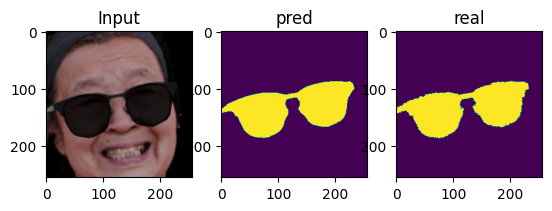

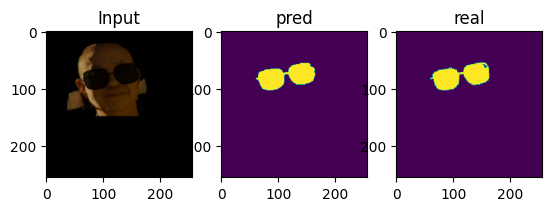

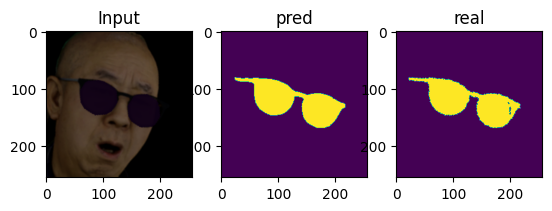

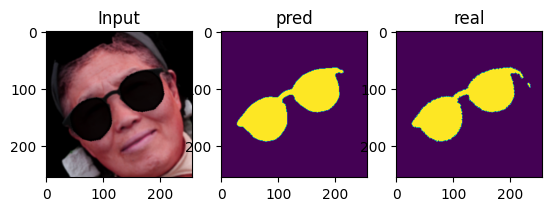

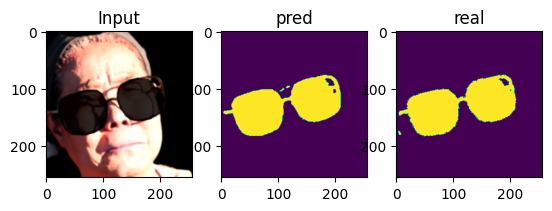

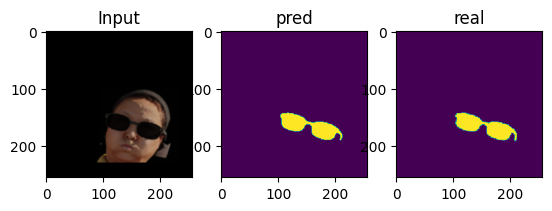

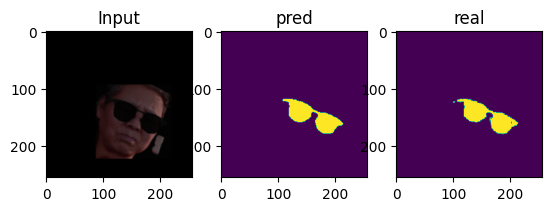

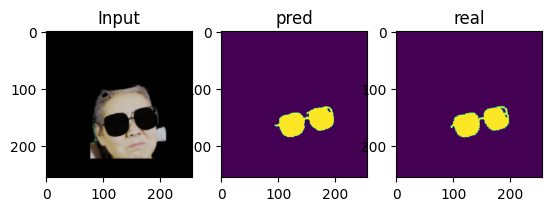

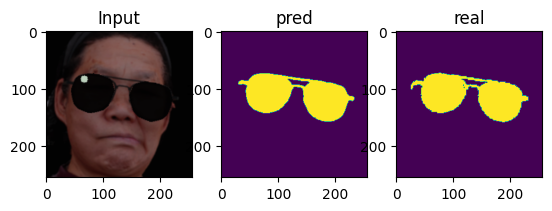

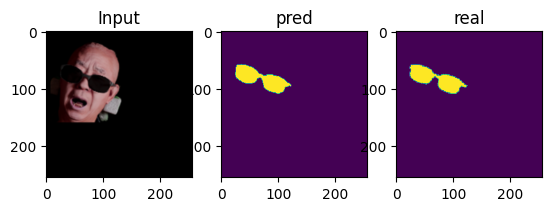

In [ ]:
model.load_state_dict(torch.load("/content/checkpoints/best.pth"))
model.to(device)

show_imgs = 10
random_list = np.random.choice(len(test_dataset), show_imgs, replace=False)

for i in range(show_imgs):
    idx = random_list[i]
    sample = test_dataset[idx]
    pred = model(sample['x'].to('cuda', dtype=torch.float32).unsqueeze(0))
    pred = torch.sigmoid(pred).squeeze(0).squeeze(0)
    pred = pred.data.cpu().numpy()
    pred = np.where(pred<0.5, 0, 1).astype(np.int16)
    pred_img = Image.fromarray(np.uint8(pred), 'L')

    img_view = sample['img_view']
    img_view = Image.fromarray(img_view, 'RGB')

    mask_view = sample['mask_view']
    mask_view = Image.fromarray(mask_view, 'L')

    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(img_view)
    axarr[0].set_title('Input')
    axarr[1].imshow(pred_img)
    axarr[1].set_title('pred')
    axarr[2].imshow(mask_view)
    axarr[2].set_title('real')
    plt.show()

In [ ]:
files.download('/content/checkpoints/best.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>